## Brain MRI Segmentation with Unet | TensorFlow and Keras

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

2022-04-28 14:31:00.382122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/paul/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-28 14:31:00.382192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Setting size parameters of images
im_width = 256
im_height = 256

## Loading the image and mask paths

In [3]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)




['../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_18.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_9.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_26.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_29.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_39.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_25.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_16.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_23.tif', '../../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_21.tif']


3929

## Plotting few images and masks

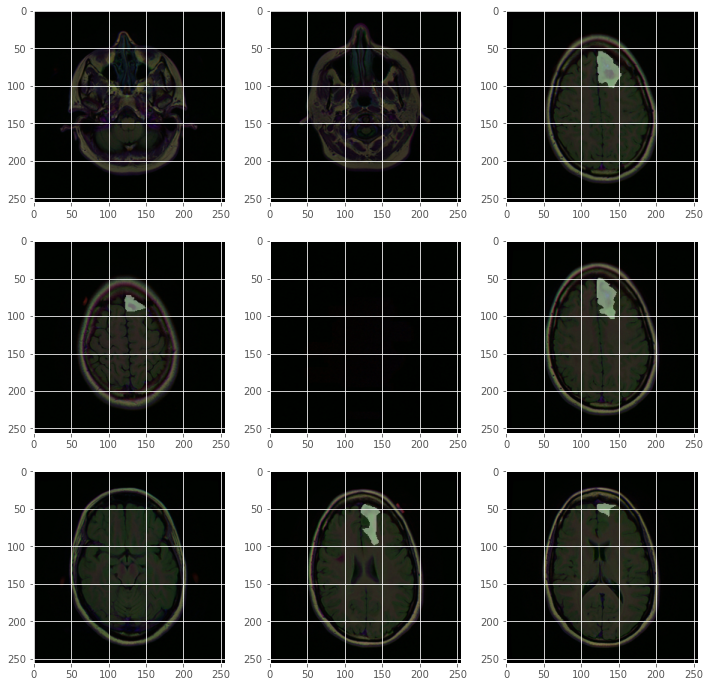

In [4]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

# **Create data frame and split data on train set, validation set and test set**

In [5]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(2828, 2)
(393, 2)
(708, 2)


## **Data genertator, data augmentation and adjust data**

In [6]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [7]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [8]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
model = unet()
model.summary

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

## Load previously trained Model

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


## Plotting Predicted Masks Segmentation results from the Test Image set

In [ ]:
for i in range(20):
    index = np.random.ranint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

    